### **Capstone Project: SkimLit**

In [ ]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

import sys
sys.path.append('/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/')

import important_functionalities as impf

**1. Data loading and pre-processing**

* Dataset: https://github.com/Franck-Dernoncourt/pubmed-rct
* For our experiments we will be using the 20k dataset with numbers replaced with '@' sign

In [ ]:
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
# check what files are in PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


**Note:** 'dev' is another word for validation set in ML

In [3]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

# check all of the filenames in the target directory
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [4]:
filenames[1]

'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt'

In [5]:
def get_lines(filename):
    '''
    Reads file given a filename (text) and returns the lines of text as a list.
    '''
    with open(filename,'r') as file:
        return file.readlines()

In [6]:
train_lines = get_lines(filenames[1])
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
len(train_lines)

210040

**1.1 How we want our data to look**
* list of dictationaries
  ```
  [{'line_number': 0,
    'target': 'BACKGROUND',
    'text': 'Emotional eating is associated with overeating and the development of obesity .'
    'total_lines':11
   },...]

  ```

* `"\n".isspace()`, we can use `.isspace()` to check for new-line characters

In [8]:
def preprocess_text_with_line_number(filename):
    '''
    Takes in filename (str), reads its content and sorts through each line.
    Extracts things like the target label, the text of the sentence, how many sentences are in the current abstract and what sentence number the target line is.
    Returns a list of dictationaries of abstract line data.
    '''

    input_lines = get_lines(filename) # get all lines from file name
    abstract_lines = '' # create an empty abstract 
    abstract_samples = [] # create an empty list of abstracts

    # loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'): # check to see if line is an ID line
            abstract_id = line
            abstract_lines = "" # reset the abstract string for every new abstract
            
        elif line.isspace(): # check to see if line is a newline
            abstract_lines_split = abstract_lines.splitlines() # split abstract into separate lines ('\n')

            # this is one particular abstract we are dealing with
            # iterate through each line in a single abstract, and count them at the same time.
            for abstract_line_no,abstract_line in enumerate(abstract_lines_split):
                line_data = {} # create an empty dictationary for each line
                target_text_split = abstract_line.split("\t")
                # text before \t is label, and after \t is text

                line_data['target'] = target_text_split[0] # get target label
                line_data['text'] = target_text_split[1].lower() # get target text and lowercase it
                line_data['line_number'] = abstract_line_no # what number line does the line appear in the abstract?
                line_data["total_lines"] = len(abstract_lines_split) - 1 # how many total lines are there in the target abstract ? (start from 0)
                
                # add line data to abstract samples list
                abstract_samples.append(line_data)

        else: # if the above conditions are not fulfilled, the line contains a labelled sentence
            abstract_lines += line
    
    return abstract_samples

In [9]:
%%time
# get data from file and pre-process it

train_samples = preprocess_text_with_line_number(data_dir+'train.txt')
val_samples = preprocess_text_with_line_number(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_number(data_dir+'test.txt')
len(train_samples),len(val_samples),len(test_samples)

CPU times: user 310 ms, sys: 88.3 ms, total: 398 ms
Wall time: 396 ms


(180040, 30212, 30135)

In [10]:
train_samples[:12]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
# # turning data into dataframe to further visualize
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [13]:
train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

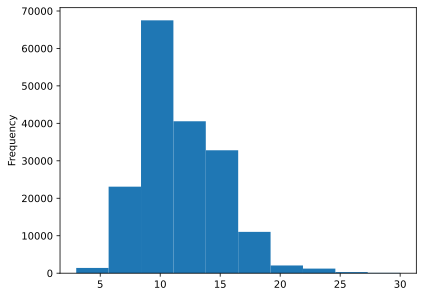

In [15]:
# lets check the length of different lines
train_df.total_lines.plot.hist();

**1.2 Getting list of sentences**

In [16]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [17]:
# view the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

**1.3 Making numeric labels**
* We will make both numeric as well as one-hot encoded

In [28]:
# NUMERIC_LABELLING
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [26]:
# ONE_HOT_ENCODING
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False) # we want non-sparse matrix

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [31]:
# Get the class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
print(class_names,num_classes)

['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS'] 5


**2. Experiments to run**

|Experiments|Model|
|---|---|
|0| Naive Bayes with TF-IDF (baseline)|
|1| Conv1D with token embeddings|
|2| Pretrained token embedding: USE-embedding layer + Dense layer|
|3| Conv1D with character embeddings|
|4| Pretrained token embeddings (same as 2) + character embedding (same as 3)|
|5| Pretrained token embeddings (same as 2) + character embedding (same as 3) + positional embeddings|

**3. Model 0: Naive Bayes with TF-IDF (baseline)**

In [32]:
### Model 0: Getting a baseline 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text (clf: classifier)
])


# fitting the pipeline to the training data
model_0.fit(train_sentences,train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [33]:
# evaluate our baseline model (default evaluation metric: accuracy)
baseline_score  = model_0.score(val_sentences,val_labels_encoded)
print(f"Our baseline model achieves an accuracy of {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of 72.18%


In [34]:
# make predictions
baseline_preds=model_0.predict(val_sentences)
baseline_preds[:20]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4, 0, 4, 1, 1, 2, 2, 4, 1, 4, 4])

In [36]:
baseline_results = impf.calculate_results(val_labels_encoded,baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

***-- CONTD IN NEXT NOTEBOOK --***